<a href="https://colab.research.google.com/github/botkin92/Data_analysis_algorithms/blob/lesson_3/Lesson_3_HW_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Напишем алгоритм логистической регрессии.

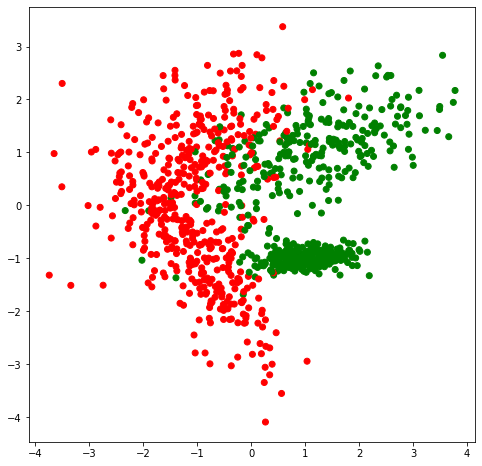

In [ ]:
from sklearn import datasets
from matplotlib.colors import ListedColormap

# сгеренируем данные с помощью sklearn.datasets
classes = datasets.make_classification(n_samples=1000, n_features=2, n_informative=2,
                                       n_redundant=0, n_classes=2, random_state=110)
# 

#classes = datasets.make_blobs(n_samples=1000,centers = 2, cluster_std = 1., random_state=12)

# и изобразим их на графике
colors = ListedColormap(['red', 'blue','green'])

plt.figure(figsize=(8, 8))
plt.scatter([x[0] for x in classes[0]], [x[1] for x in classes[0]], c=classes[1], cmap=colors)
plt.show()

Далее разделим выборку на обучающую и тестовую. При реальной работе, если нет специфических требований по сохранению порядка выборки, ее полезно перемешивать, так как данные в ней могут быть каким-либо образом отсортированы. Это может негативно сказаться на процессе обучения.

In [ ]:
# перемешивание датасета
np.random.seed(12)
shuffle_index = np.random.permutation(classes[0].shape[0])
X_shuffled, y_shuffled = classes[0][shuffle_index], classes[1][shuffle_index]

# разбивка на обучающую и тестовую выборки
train_proportion = 0.9
train_test_cut = int(len(classes[0]) * train_proportion)

X_train, X_test, y_train, y_test = \
    X_shuffled[:train_test_cut], \
    X_shuffled[train_test_cut:], \
    y_shuffled[:train_test_cut], \
    y_shuffled[train_test_cut:]
    
print("Размер массива признаков обучающей выборки", X_train.shape)
print("Размер массива признаков тестовой выборки", X_test.shape)
print("Размер массива ответов для обучающей выборки", y_train.shape)
print("Размер массива ответов для тестовой выборки", y_test.shape)

Размер массива признаков обучающей выборки (900, 2)
Размер массива признаков тестовой выборки (100, 2)
Размер массива ответов для обучающей выборки (900,)
Размер массива ответов для тестовой выборки (100,)


Далее транспонируем матрицы данных, так как нам удобнее работать со строками

In [ ]:
X_train_tr = X_train.transpose()
y_train_tr = y_train.reshape(1, y_train.shape[0])
X_test_tr = X_test.transpose()
y_test_tr = y_test.reshape(1, y_test.shape[0])

Реализуем функцию потерь log loss с одновременным расчетом градиента.

Оптимизировать функционал ошибки будем с помощью градиентного спуска, его вид в случае использования такой функции потерь будет:

$$w_{n+1} = w_{n} - \eta \frac{1}{l}X(A-Y)^{T},$$

где $A=\frac{1}{1 + exp(-\left \langle w,x_{i} \right \rangle)}.$

In [ ]:
def log_loss(w, X, y):
    m = X.shape[1]

    # используем функцию сигмоиды, написанную ранее
    A = sigmoid(np.dot(w.T, X))
    
    loss = -1.0 / m * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
    loss = np.squeeze(loss)
    grad = 1.0 / m * np.dot(X, (A - y).T)
    
    return loss, grad

Реализуем градиентный спуск

In [ ]:
def optimize(w, X, y, n_iterations, eta):
#     потери будем записывать в список для отображения в виде графика
    losses = []
    
    for i in range(n_iterations):        
        loss, grad = log_loss(w, X, y)
        w = w - eta * grad

        losses.append(loss)
        
    return w, losses

и функцию для выполнения предсказаний

In [ ]:
def predict(w, X):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность 0.5
    for i in range(A.shape[1]):
        if (A[:,i] > 0.5): 
            y_predicted[:, i] = 1
        elif (A[:,i] <= 0.5):
            y_predicted[:, i] = 0
    
    return y_predicted

## Домашнее задание

1. Измените функцию predict(w, X) так, чтобы можно было подать порог для классификации.

In [ ]:
def predict(w, X, a):
    
    m = X.shape[1]
    
    y_predicted = np.zeros((1, m))
    w = w.reshape(X.shape[0], 1)
    
    A = sigmoid(np.dot(w.T, X))
    
#     За порог отнесения к тому или иному классу примем вероятность a
    if a >= 0 and a <= 1: 
        for i in range(A.shape[1]):
            if (A[:,i] > a): 
                y_predicted[:, i] = 1
            elif (A[:,i] <= a):
                y_predicted[:, i] = 0
    else:
        return f'Порог вероятности a не принадлежит диапазону [0, 1]'

    return y_predicted

2. Подберите аргументы функции optimize для логистической регрессии таким образом, чтобы log loss был минимальным.

In [ ]:
w0 = np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 50
eta = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]

total_losses = []
w_list = []

for x in eta:
  w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, x)
  
  total_losses.append(losses[-1])
  w_list.append(w)

# print(w_list)
# print(min(total_losses))

print(f'Минимальный logloss составил {min(total_losses):.3f} при весовых коэффициентах w: {w_list[total_losses.index(min(total_losses))]} и шаге обучения eta: {eta[total_losses.index(min(total_losses))]}')

Минимальный logloss составил 0.268 при весовых коэффициентах w: [[ 2.87020352e+00]
 [-1.41567142e-03]] и шаге обучения eta: 10


Изменим начальные коэффициенты:

In [ ]:
w0 = np.array([[-5.], [5.]]) # np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 50
eta = [0.01, 0.05, 0.1, 0.5, 1, 5, 10]

total_losses = []
w_list = []

for x in eta:
  w, losses = optimize(w0, X_train_tr, y_train_tr, n_iterations, x)
  
  total_losses.append(losses[-1])
  w_list.append(w)

# print(w_list)
# print(min(total_losses))

print(f'Минимальный logloss составил {min(total_losses):.3f} при весовых коэффициентах w: {w_list[total_losses.index(min(total_losses))]} и шаге обучения eta: {eta[total_losses.index(min(total_losses))]}')

Минимальный logloss составил 0.268 при весовых коэффициентах w: [[ 2.87020285e+00]
 [-1.41569516e-03]] и шаге обучения eta: 10


3. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

In [ ]:
y_predicted_test = predict(w, X_test_tr, 0.5)
y_predicted_train = predict(w, X_train_tr, 0.5)

In [ ]:
ind_i, ind_j = np.where(y_train_tr == 1) # индексы где истинные ответы принимают 1

TP = 0
FN = 0

for j in ind_j:
  if y_train_tr[0][j] == y_predicted_train[0][j]:
    TP += 1
  else:
    FN += 1
print(f'True Positive: {TP}, False Negative: {FN}')

True Positive: 410, False Negative: 49


In [ ]:
ind_i, ind_j = np.where(y_train_tr == 0) # индексы где истинные ответы принимают 0

FP = 0
TN = 0

for j in ind_j:
  if y_train_tr[0][j] == y_predicted_train[0][j]:
    TN += 1
  else:
    FP += 1
print(f'True Negative: {TN}, False Positive: {FP}')

True Negative: 392, False Positive: 49


In [ ]:
train_accuracy = np.sum(y_train_tr == y_predicted_train) / y_train_tr.shape[1]
print(f'Accuracy: {train_accuracy:.2f}')

Accuracy: 0.89


In [ ]:
error_matrix = np.array([[TP, FP], [FN, TN]])
print(error_matrix)

[[410  49]
 [ 49 392]]


In [ ]:
train_preсision = TP / (TP + FP)
train_recall = TP / (TP + FN)
print(f'Preсision: {train_preсision:.2f}, Recall: {train_recall:.2f}')

Preсision: 0.89, Recall: 0.89


In [ ]:
train_F1 = 2 * train_preсision * train_recall / (train_preсision + train_recall)
print(f'F1 score: {train_F1:.2f}')

F1 score: 0.89


In [ ]:
# Проверка:
from sklearn.metrics import classification_report

print(classification_report(pd.Series(y_train_tr[0]), pd.Series(y_predicted_train[0])))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       441
           1       0.89      0.89      0.89       459

    accuracy                           0.89       900
   macro avg       0.89      0.89      0.89       900
weighted avg       0.89      0.89      0.89       900



4. Постройте кривую обучения (значение оценки потерь от итерации) для примеров из тренировочной и тестовой выборки

In [ ]:
# иницилизируем начальный вектор весов
w0 = np.zeros((X_train_tr.shape[0], 1))-1

n_iterations = 20
eta = 0.55

w_tr, losses_tr = optimize(w0, X_train_tr, y_train_tr, n_iterations, eta)
w_tst, losses_tst = optimize(w0, X_test_tr, y_test_tr, n_iterations, eta)

<function matplotlib.pyplot.show>

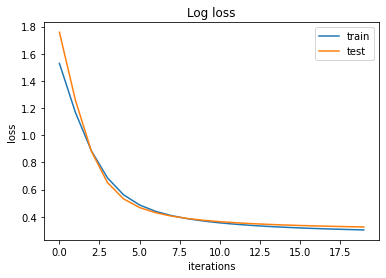

In [ ]:
ox = [i for i in range(n_iterations)]
oy_train = losses_tr
oy_test = losses_tst

plt.plot(ox, oy_train)
plt.plot(ox, oy_test)

plt.title('Log loss')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend(['train', 'test'])
plt.show

5. Оцените результаты и сделайте выводы.

Функции потерь log loss по тренировочной и тестовой выборке схожи. Переобучение не наблюдается.

6. Попробуйте ответить на вопросы: Могла ли модель переобучиться? На каком шаге это произошло? Почему?